# Libraries and versions

In [1]:
python_version = !python -V #version 3.8.8
import pandas as pd #version 1.2.4
import numpy as np #version 1.20.1
import seaborn as sns #version 0.11.1
import matplotlib as plt #version 3.3.4

#Modelo
from sklearn.metrics import mean_squared_log_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit

#salvar modelo
import pickle

In [2]:
print(f'Python version - {python_version[0][7:]}')
print(f'Pandas version - {pd.__version__}')
print(f'Numpy version - {np.__version__}')
print(f'Seaborn version - {sns.__version__}')
print(f'Matplotlib version - {plt.__version__}')

Python version - 3.8.8
Pandas version - 1.2.4
Numpy version - 1.20.1
Seaborn version - 0.11.1
Matplotlib version - 3.3.4


# Configurations

## Pandas

In [3]:
#apresentará 500 colunas e linhas
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 20)

## Seaborn

In [4]:
sns.set_palette('inferno')
sns.set_style('darkgrid')

def configuration(graphic_object, title=None, xlabel=None, ylabel=None, colors=None):
    graphic_object.figure.set_size_inches(20,8)
    graphic_object.set_title(title, color=colors, fontsize=16)
    graphic_object.set_xlabel(xlabel, color=colors, fontsize=14)
    graphic_object.set_ylabel(ylabel, color=colors, fontsize=14)
    graphic_object = graphic_object

## Warnings

In [5]:
import warnings
warnings.filterwarnings("ignore")

## Base

In [6]:
bvsp = pd.read_csv('bvsp_modelado_original.csv')
bvsp.head()

,data,abertura,alta,baixa,fechamento,var_abertura,media_movel_180,media_movel_240,media_movel_360,media_movel_480
0,1995-02-27,3217.399902,3345.800049,3184.399902,3270.899902,0.000000,4404.944448,3785.654587,2719.633892,2057.587711
1,1995-02-28,3217.399902,3345.800049,3184.399902,3270.899902,0.000000,4404.830560,3792.938337,2728.090837,2064.238961
2,1995-03-01,3217.399902,3345.800049,3184.399902,3270.899902,0.000000,4404.943892,3800.340836,2736.526114,2070.890836
3,1995-03-02,3270.899902,3270.899902,2970.199951,2989.100098,53.500000,4405.345558,3807.966252,2745.099169,2077.654585
4,1995-03-03,2989.100098,3018.100098,2841.699951,2988.000000,-281.799804,4404.507225,3814.417502,2752.882781,2083.832502


### Informações

In [7]:
bvsp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6637 entries, 0 to 6636
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   data             6637 non-null   object 
 1   abertura         6637 non-null   float64
 2   alta             6637 non-null   float64
 3   baixa            6637 non-null   float64
 4   fechamento       6637 non-null   float64
 5   var_abertura     6637 non-null   float64
 6   media_movel_180  6637 non-null   float64
 7   media_movel_240  6637 non-null   float64
 8   media_movel_360  6637 non-null   float64
 9   media_movel_480  6637 non-null   float64
dtypes: float64(9), object(1)
memory usage: 518.6+ KB


### Transformar índice em data

In [8]:
#transforma coluna em data
bvsp['data'] = pd.to_datetime(bvsp['data'])

#transforma o índice em data
bvsp.set_index('data', inplace=True)

### Separar dados de treino e validação

In [9]:
dt_treino = bvsp.loc[:'2020-05-29']
dt_validacao = bvsp.loc['2020-06-01':]

### Fechamento

1° iteração
Perído Treino - 1995-02-27 00:00:00 / 1996-02-27 00:00:00
Amostra Treino - 262
Período Teste - 1996-02-28 00:00:00 / 1997-02-18 00:00:00
Amostra Teste - 255
Erro Médio Quadrático = 0.00728
R2 = 0.60422
2° iteração
Perído Treino - 1995-02-27 00:00:00 / 1997-02-18 00:00:00
Amostra Treino - 517
Período Teste - 1997-02-19 00:00:00 / 1998-02-10 00:00:00
Amostra Teste - 255
Erro Médio Quadrático = 0.00112
R2 = 0.93578
3° iteração
Perído Treino - 1995-02-27 00:00:00 / 1998-02-10 00:00:00
Amostra Treino - 772
Período Teste - 1998-02-11 00:00:00 / 1999-02-02 00:00:00
Amostra Teste - 255
Erro Médio Quadrático = 0.00200
R2 = 0.97260
4° iteração
Perído Treino - 1995-02-27 00:00:00 / 1999-02-02 00:00:00
Amostra Treino - 1027
Período Teste - 1999-02-03 00:00:00 / 2000-01-25 00:00:00
Amostra Teste - 255
Erro Médio Quadrático = 0.00048
R2 = 0.98399
5° iteração
Perído Treino - 1995-02-27 00:00:00 / 2000-01-25 00:00:00
Amostra Treino - 1282
Período Teste - 2000-01-26 00:00:00 / 2001-01-16 00

<AxesSubplot:>

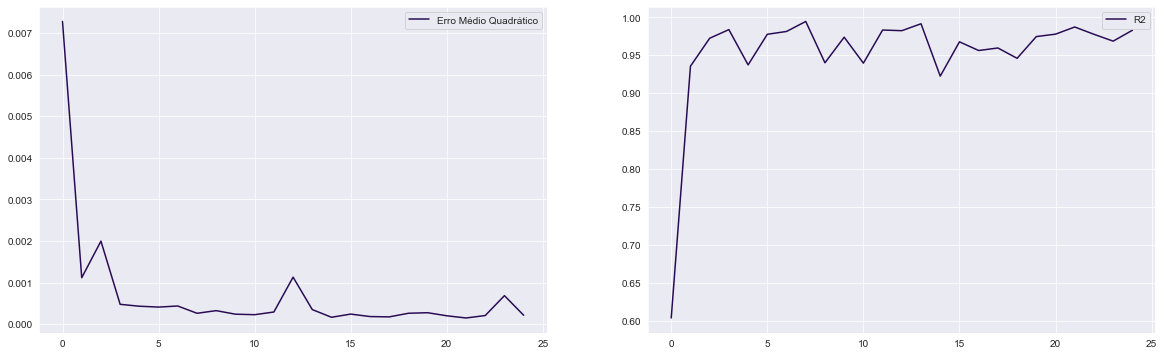

In [10]:
X = bvsp.drop(columns=['alta', 'baixa', 'fechamento'])
y_fechamento = bvsp['fechamento']

divisoes = 25
tscv = TimeSeriesSplit(n_splits=divisoes)
contador = 0
lista_erro = []
lista_iteracao = []
lista_r2 = []
for treino_indice, teste_indice in tscv.split(X):
    X_treino, X_teste = X.iloc[treino_indice], X.iloc[teste_indice]
    y_treino_fechamento, y_teste_fechamento = y_fechamento[treino_indice], y_fechamento[teste_indice]
    
    #modelo
    mdl_fechamento = Ridge()
    mdl_fechamento.fit(X_treino, y_treino_fechamento)
    y_fechamento_previsto = mdl_fechamento.predict(X_teste)
    
    #precisão
    erro = mean_squared_log_error(y_teste_fechamento, y_fechamento_previsto)
    r2 = r2_score(y_teste_fechamento, y_fechamento_previsto)
    
    #incrementa lista e contador
    lista_erro.append(erro)
    lista_iteracao.append(contador)
    lista_r2.append(r2)
    contador += 1
        
    print(f'{contador}° iteração')
    print(f'Perído Treino - {X_treino.index[0]} / {X_treino.index[-1]}')
    print(f'Amostra Treino - {X_treino.shape[0]}')
    print(f'Período Teste - {y_teste_fechamento.index[0]} / {y_teste_fechamento.index[-1]}')
    print(f'Amostra Teste - {len(y_teste_fechamento)}')
    print(f'Erro Médio Quadrático = {erro:.5f}\nR2 = {r2:.5f}')
    print('='*90)

fig, axes = plt.pyplot.subplots(1,2, figsize=(20,6))    
sns.lineplot(x=lista_iteracao, y=lista_erro, ax=axes[0], label='Erro Médio Quadrático')
sns.lineplot(x=lista_iteracao, y=lista_r2, ax=axes[1], label='R2')

### Baixa

1° iteração
Perído Treino - 1995-02-27 00:00:00 / 1996-02-27 00:00:00
Amostra Treino - 262
Período Teste - 1996-02-28 00:00:00 / 1997-02-18 00:00:00
Amostra Teste - 255
Erro Médio Quadrático = 0.00028
R2 = 0.98485
2° iteração
Perído Treino - 1995-02-27 00:00:00 / 1997-02-18 00:00:00
Amostra Treino - 517
Período Teste - 1997-02-19 00:00:00 / 1998-02-10 00:00:00
Amostra Teste - 255
Erro Médio Quadrático = 0.00079
R2 = 0.95321
3° iteração
Perído Treino - 1995-02-27 00:00:00 / 1998-02-10 00:00:00
Amostra Treino - 772
Período Teste - 1998-02-11 00:00:00 / 1999-02-02 00:00:00
Amostra Teste - 255
Erro Médio Quadrático = 0.00186
R2 = 0.97733
4° iteração
Perído Treino - 1995-02-27 00:00:00 / 1999-02-02 00:00:00
Amostra Treino - 1027
Período Teste - 1999-02-03 00:00:00 / 2000-01-25 00:00:00
Amostra Teste - 255
Erro Médio Quadrático = 0.00031
R2 = 0.98981
5° iteração
Perído Treino - 1995-02-27 00:00:00 / 2000-01-25 00:00:00
Amostra Treino - 1282
Período Teste - 2000-01-26 00:00:00 / 2001-01-16 00

<AxesSubplot:>

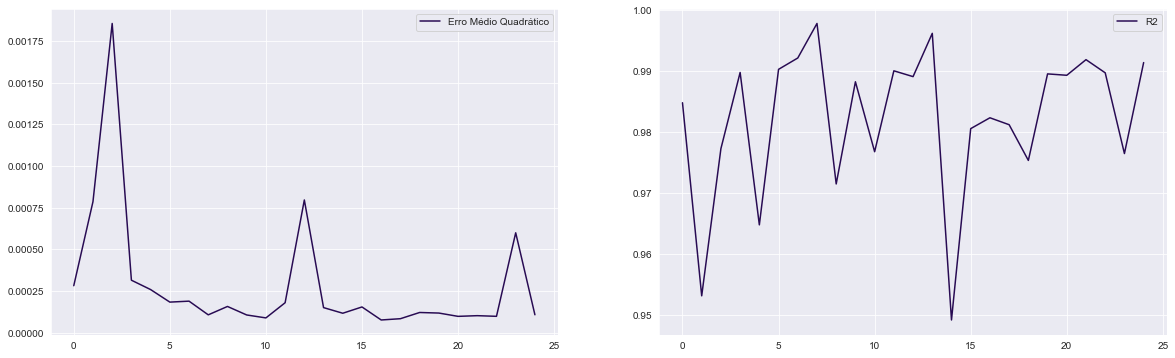

In [11]:
X = bvsp.drop(columns=['alta', 'baixa', 'fechamento'])
y_baixa = bvsp['baixa']

divisoes = 25
tscv = TimeSeriesSplit(n_splits=divisoes)
contador = 0
lista_erro = []
lista_iteracao = []
lista_r2 = []
for treino_indice, teste_indice in tscv.split(X):
    X_treino, X_teste = X.iloc[treino_indice], X.iloc[teste_indice]
    y_treino_baixa, y_teste_baixa = y_baixa[treino_indice], y_baixa[teste_indice]
    
    #modelo
    mdl_baixa = Ridge(alpha=2.0)
    mdl_baixa.fit(X_treino, y_treino_baixa)
    y_baixa_previsto = mdl_baixa.predict(X_teste)
    
    #precisão
    erro = mean_squared_log_error(y_teste_baixa, y_baixa_previsto)
    r2 = r2_score(y_teste_baixa, y_baixa_previsto)
    
    #incrementa lista e contador
    lista_erro.append(erro)
    lista_iteracao.append(contador)
    lista_r2.append(r2)
    contador += 1
        
    print(f'{contador}° iteração')
    print(f'Perído Treino - {X_treino.index[0]} / {X_treino.index[-1]}')
    print(f'Amostra Treino - {X_treino.shape[0]}')
    print(f'Período Teste - {y_teste_baixa.index[0]} / {y_teste_baixa.index[-1]}')
    print(f'Amostra Teste - {len(y_teste_baixa)}')
    print(f'Erro Médio Quadrático = {erro:.5f}\nR2 = {r2:.5f}')
    print('='*90)

fig, axes = plt.pyplot.subplots(1,2, figsize=(20,6))    
sns.lineplot(x=lista_iteracao, y=lista_erro, ax=axes[0], label='Erro Médio Quadrático')
sns.lineplot(x=lista_iteracao, y=lista_r2, ax=axes[1], label='R2')

### Alta

1° iteração
Perído Treino - 1995-02-27 00:00:00 / 1996-02-27 00:00:00
Amostra Treino - 262
Período Teste - 1996-02-28 00:00:00 / 1997-02-18 00:00:00
Amostra Teste - 255
Erro Médio Quadrático = 0.00509
R2 = 0.71434
2° iteração
Perído Treino - 1995-02-27 00:00:00 / 1997-02-18 00:00:00
Amostra Treino - 517
Período Teste - 1997-02-19 00:00:00 / 1998-02-10 00:00:00
Amostra Teste - 255
Erro Médio Quadrático = 0.00070
R2 = 0.96396
3° iteração
Perído Treino - 1995-02-27 00:00:00 / 1998-02-10 00:00:00
Amostra Treino - 772
Período Teste - 1998-02-11 00:00:00 / 1999-02-02 00:00:00
Amostra Teste - 255
Erro Médio Quadrático = 0.00088
R2 = 0.98737
4° iteração
Perído Treino - 1995-02-27 00:00:00 / 1999-02-02 00:00:00
Amostra Treino - 1027
Período Teste - 1999-02-03 00:00:00 / 2000-01-25 00:00:00
Amostra Teste - 255
Erro Médio Quadrático = 0.00027
R2 = 0.99037
5° iteração
Perído Treino - 1995-02-27 00:00:00 / 2000-01-25 00:00:00
Amostra Treino - 1282
Período Teste - 2000-01-26 00:00:00 / 2001-01-16 00

<AxesSubplot:>

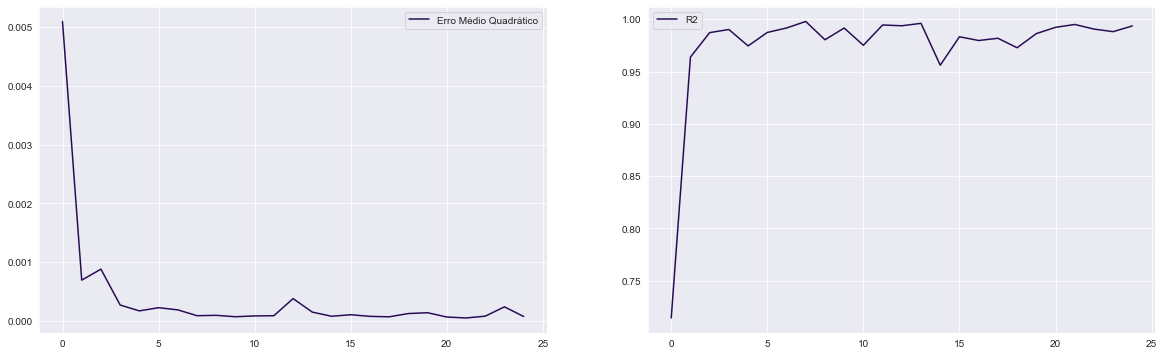

In [12]:
X = bvsp.drop(columns=['alta', 'baixa', 'fechamento'])
y_alta = bvsp['alta']

divisoes = 25
tscv = TimeSeriesSplit(n_splits=divisoes)
contador = 0
lista_erro = []
lista_iteracao = []
lista_r2 = []
for treino_indice, teste_indice in tscv.split(X):
    X_treino, X_teste = X.iloc[treino_indice], X.iloc[teste_indice]
    y_treino_alta, y_teste_alta = y_alta[treino_indice], y_alta[teste_indice]
    
    #modelo
    mdl_alta = Ridge(alpha=2.0)
    mdl_alta.fit(X_treino, y_treino_alta)
    y_alta_previsto = mdl_alta.predict(X_teste)
    
    #precisão
    erro = mean_squared_log_error(y_teste_alta, y_alta_previsto)
    r2 = r2_score(y_teste_alta, y_alta_previsto)
    
    #incrementa lista e contador
    lista_erro.append(erro)
    lista_iteracao.append(contador)
    lista_r2.append(r2)
    contador += 1
        
    print(f'{contador}° iteração')
    print(f'Perído Treino - {X_treino.index[0]} / {X_treino.index[-1]}')
    print(f'Amostra Treino - {X_treino.shape[0]}')
    print(f'Período Teste - {y_teste_alta.index[0]} / {y_teste_alta.index[-1]}')
    print(f'Amostra Teste - {len(y_teste_alta)}')
    print(f'Erro Médio Quadrático = {erro:.5f}\nR2 = {r2:.5f}')
    print('='*90)

fig, axes = plt.pyplot.subplots(1,2, figsize=(20,6))    
sns.lineplot(x=lista_iteracao, y=lista_erro, ax=axes[0], label='Erro Médio Quadrático')
sns.lineplot(x=lista_iteracao, y=lista_r2, ax=axes[1], label='R2')

## Salvar modelo

### Fechamento

In [13]:
#nome do modelo
arquivo_fechamento = 'mdlfechamento.ridge.v1.sav'

#salvando o modelo
pickle.dump(mdl_fechamento, open(arquivo_fechamento, 'wb'))

### Baixa

In [14]:
#nome do modelo
arquivo_baixa = 'mdlbaixa.ridge.v1.sav'

#salvando o modelo
pickle.dump(mdl_baixa, open(arquivo_baixa, 'wb'))

### Alta

In [15]:
#nome do modelo
arquivo_alta = 'mdlalta.ridge.v1.sav'

#salvando o modelo
pickle.dump(mdl_alta, open(arquivo_alta, 'wb'))